# About this notebook

This notebook was written for the [2016 Construction grammar course](http://budling.hu/elmnyelv/index.php/Constructions2016) at the [Department of Theoretical Linguistics](http://www.nytud.hu/tlp/index.html). In this experiment, we try to establish if there are preverbs which correlate with certain argument types to a statistically significant extent. This is also an introductory notebook, which touches on some advanced topics, such as `DataFrame` joining and data plotting. For the first part of the introduction, refer to the [Pandas tutorial](Pandas tutorial.ipynb)

## Basic setup

The first part of the file shows how to download the corpus to your computer and then how to load it into a [Pandas](http://pandas.pydata.org/) *dataframe* (i.e. table).

In [25]:
import pandas as pd
# So that plots work correctly
%matplotlib inline   

import matplotlib
import numpy as np
from IPython.display import display  # For display()

By default, the code in this notebook creates files in the current directory, i.e. the one from which you started the notebook. To use a different directory, just change the value of the `work_directory` variable.

In [26]:
import os

work_directory = os.path.abspath('.')
data_file = 'tade.tsv'

if not os.path.isdir(work_directory):
    os.makedirs(work_directory)
os.chdir(work_directory)

print("The working directory is: " + os.getcwd())

The working directory is: /run/shm/Tade-corpus-tools/notebooks


Finally, we set up plotting. It would work without these commands (since we imported `matplotlib` above), but it looks nicer this way.

In [27]:
matplotlib.style.use('ggplot')
#pd.set_option('display.mpl_style', 'default')
matplotlib.pyplot.rcParams['figure.figsize'] = (15, 3)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'

## Getting the data into a table

The first step is to download the Tádé file if it is not downloaded yet. Remember to execute the cell above before this one so that you are in the data directory you specified.

In [28]:
if not os.path.exists(data_file):
    import urllib
    u = urllib.request.URLopener()
    print('Downloading Tádé...')
    u.retrieve('http://people.mokk.bme.hu/~recski/verb_clusters/tade.tsv', 'tade.tsv')
    print('Done.')
else:
    print('Tádé is already downloaded.')

Tádé is already downloaded.


Now that we have the file, we can read it into a `DataFrame` and start working on our experiments... The file is in the Latin-2 (ISO-8859-2) encoding, which is not the default in Python (nor in the modern world) -- that title belongs to utf-8. So in order to be able to properly load the file, we need to specify the encoding as well.

In [29]:
column_names = ['verb', 'frame', 'frame_freq', 'verb_freq', 'freq_ratio']
df = pd.read_table(data_file, encoding='latin2', sep='\t', names=column_names)
df.frame = df.frame.apply(str.upper)
print('Loaded ' + data_file + '; read ' + str(len(df)) + ' lines. The first five lines are:')
df.head()

Loaded tade.tsv; read 1158484 lines. The first five lines are:


,verb,frame,frame_freq,verb_freq,freq_ratio
0,van,@,362298,908829,0.398643
1,van,NP<CAS<INE>>,71800,908829,0.079003
2,van,NP<CAS<DAT>>,56905,908829,0.062614
3,van,NP<CAS<SBL>>,35869,908829,0.039467
4,van,NP<CAS<SUE>>,29836,908829,0.032829


## Significant Arguments

Now we can start with the real experiment. We will use [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher's_exact_test) to evaluate the correlation between preverb and argument. An implementation is available in the [scipy library](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html), which was brought along by Pandas. Basically what we will measure is the odds of a preverb co-occuring with and without an argument (e.g. _rá_ and _CAS&lt;SBL&gt;_, and _rá_ only) vs the same odds for verbs without the preverb (i.e. frames with and without _CAS&lt;SBL&gt;_). This will give us the so called _p-value_, which tells us the probability of the the correlation **NOT** holding.

### Data transformations

Unfortunately, the data, in its current format, is not the best suited for the calculations we need. So a few transformations are in order:

1. The _INF_ frame is not recorded explicitly in the `frame` column; rather, the lemma of infinite verb is appended to the finite one, e.g. `akar_fut`. For such rows, we will delete the part after the underscore and add _INF_ to the frame.
1. The empty frame is marked with an at sign (`@`). Since we don't care about those (but we could!), we shall change these frames to `np.nan`. The _NaN_ (Not a Number) value tells Pandas that the cell is empty, and is valid for all column types (as opposed to e.g. 0, which is only valid for numeric columns). An added bonus is that such cells are not taken into account when grouping by the column, which we will need to do.
1. Actually, we don't really care about the verbs at all, only the preverbs. So we will add a column to the frame that stores only the preverb, i.e. the part before the `+` in verbs such as `meg+próbál`.
1. Finally, if there is a compound argument, such as `NP<CAS<ACC>>_NP<CAS<DAT>>`, we will have to count it both for _ACC_ and _DAT_. It will be much easier if we split such rows into as many rows as there are arguments, and just have a single argument per row. So in this case, we duplicate the row, and keep each cell as-is, with the exception of `frame`, which will be `NP<CAS<ACC>>` in the first row and `NP<CAS<DAT>>` in the second.

The functions below implement these changes.

In [30]:
def split_frames(df):
    """
    Splits the frames into individual arguments and creates as many copies of the row
    as there are arguments in the frame. Makes certain calculations easier.
    """
    s = df.frame.str.split('_').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1)  # Drops the second-level index (0, 1, ...) created by stack()
    s.name = 'frame'                 # Needs a name for join
    return df.drop('frame', axis=1).join(s)[df.columns]  # Keep the original column order

def normalize_frames(df, in_place=True):
    """
    This function does two things: first, it adds INF as a frame if the verb is a modal
    (i.e. the 'verb' column is of the format FiniteVerb_InfiniteVerb). Second, it replaces
    the '@' (empty) frame marker with numpy.nan for better grouping support later on.
    """
    df_ret = df if in_place else df.copy(deep=True)
    df_ret.frame = df_ret.frame.apply(lambda s: 'INF' if s == '@' else s + '_INF').where(
        df_ret.verb.str.contains('_', regex=False), other=df_ret.frame)
    df_ret.loc[df_ret.verb.str.contains('_', regex=False), 'verb'] = df_ret.verb.str.replace('_.*', '')
    #df_ret.loc[df_ret.frame == '@', 'frame'] = np.nan
    return df_ret

def add_preverb_column(df):
    """Adds a preverb column to the data frame."""
    return df.assign(preverb=df.verb.str.replace('[+].+', '').where(df.verb.str.contains('+', regex=False)))

***Note***: `split_frames` will not work on non-server machines, as it requires too much memory. So we are going to use another method; see below.

### Culling the data

Unfortunately, even if the original data fits into the memory of a moderately recent notebook, the frame with the split frames takes up about 3 times as much space, and will find even 8G scarce. So it is best if we remove columns that we do not need, which (after calling `add_preverb_column()`) includes even the `verb` column.

In [31]:
df.drop(['verb_freq', 'freq_ratio'], axis=1, inplace=True)
display(df.head())
df = add_preverb_column(normalize_frames(df)).drop('verb', axis=1)

,verb,frame,frame_freq
0,van,@,362298
1,van,NP<CAS<INE>>,71800
2,van,NP<CAS<DAT>>,56905
3,van,NP<CAS<SBL>>,35869
4,van,NP<CAS<SUE>>,29836


### Plotting

Running the functions above on our table results in a much easier-to-handle one. One thing that is really a one-liner now is to get the number of times each preverb or argument occurs in the corpus; it is just a matter of grouping the table and aggregating the rows:

1. If we aggregate with `count()` (the column is not important in this case), we will get for each preverb the number of verbs it attaches to.
1. Aggregating the `frame_freq` column by `preverb` with `sum()` tells us the number of times each preverb occurs. These two aggregations should be done **before** splitting the frames, otherwise the duplicated frequencies that help us in the second case mess up things.
1. After splitting the frames, aggregating the `frame_freq` column by `frame` with `sum()` gives us the raw number of times an argument occurs in the corpus.
1. Finally, grouping by both preverb and argument gives us the co-occurrance table.

In [32]:
print("df_with_preverbs.info:\n{}\n".format(df.info()))
def real_frame_size(df):
    import sys
    return sum(sum(df[c].apply(sys.getsizeof)) for c in df.columns)
print(real_frame_size(df))

preverb_counts = df[['preverb', 'frame_freq']].rename(columns={'frame_freq': 'count'}).groupby('preverb').count()
preverb_sums = df[['preverb', 'frame_freq']].rename(columns={'frame_freq': 'B'}).groupby('preverb').sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158484 entries, 0 to 1158483
Data columns (total 3 columns):
frame         1158484 non-null object
frame_freq    1158484 non-null int64
preverb       340906 non-null object
dtypes: int64(1), object(2)
memory usage: 26.5+ MB
df_with_preverbs.info:
None

184807245


In [33]:
#s = df.frame.str.split('_').apply(pd.Series, 1)
from functools import reduce
frames = reduce(lambda acc, e: acc | set(e.split('_')) if type(e) == str else acc, df.frame, set())
len(frames)

416

In [48]:
## Too damn bloody slow
#for frame in frames:
#    df[frame] = df.apply(lambda row: frame in row['frame'] if type(row['frame']) == str else False, axis=1)

from collections import Counter

# This is a f*cking shame
frame_counter = Counter()
cell_counter = Counter()
for t in df.itertuples():
    for frame in t.frame.split('_'):
        frame_counter[frame] += t.frame_freq
        if t.preverb:
            cell_counter[(t.preverb, frame)] += t.frame_freq

In [53]:
frame_sums = pd.DataFrame(list(frame_counter.items()), columns=['frame', 'C']).set_index('frame')
cells = pd.DataFrame(list((pf[0], pf[1], a) for pf, a in cell_counter.items()), columns=['preverb', 'frame', 'A']).set_index(['preverb', 'frame'])

,C
frame,
PP<KÍVÜLI>,159
PP<KÖZÖTTEM>,2
PP<ALATTI>,182
PP<FELETTIVEL>,2
PP<ELŐTTIJE>,1


A
preverb frame           
le      PP<TÚLRÓL>     3
létre   PP<INNEN>      1
kinn    NP<CAS<ACC>>   1
alá     PP<EGYÜTT>    21
        PP<ÓTA>       15

***Note***: The names (_A_, _B_, _C_, _D_ are the same as on the [Wikipedia page](https://en.wikipedia.org/wiki/Fisher's_exact_test).)

We could print the content of these tables to see e.g. the number of different verbs for each preverb, but for the more visual types out there, there is another option: plotting. The histogram below shows just this (note the sorting, and also how we aggregate the rest of the preverbs):

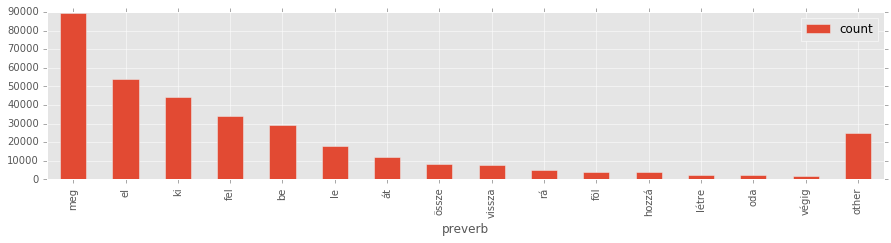

In [117]:
def capped_sorted_list(lst, by, cutoff=0, other='other'):
    """
    Sorts a data frame by the specified column decreasingly. It allows the user to
    specify a cutoff; all items with indices above this cutoff are aggregated under
    (with sum) under an "other" item.
    """
    slst = lst.sort_values(by=by, ascending=False)
    if cutoff > 0:
        slst = slst[:cutoff].append(
            pd.DataFrame([[other, slst[cutoff:].sum()[0]]],
                         columns=lst.index.names + list(lst.columns.values)).set_index(lst.index.names)
        )
    return slst

capped_sorted_list(preverb_counts, by='count', cutoff=15).plot(y='count', kind='bar')

We can also display the number of frames for the top arguments and preverbs. Let's do it in two pie charts!

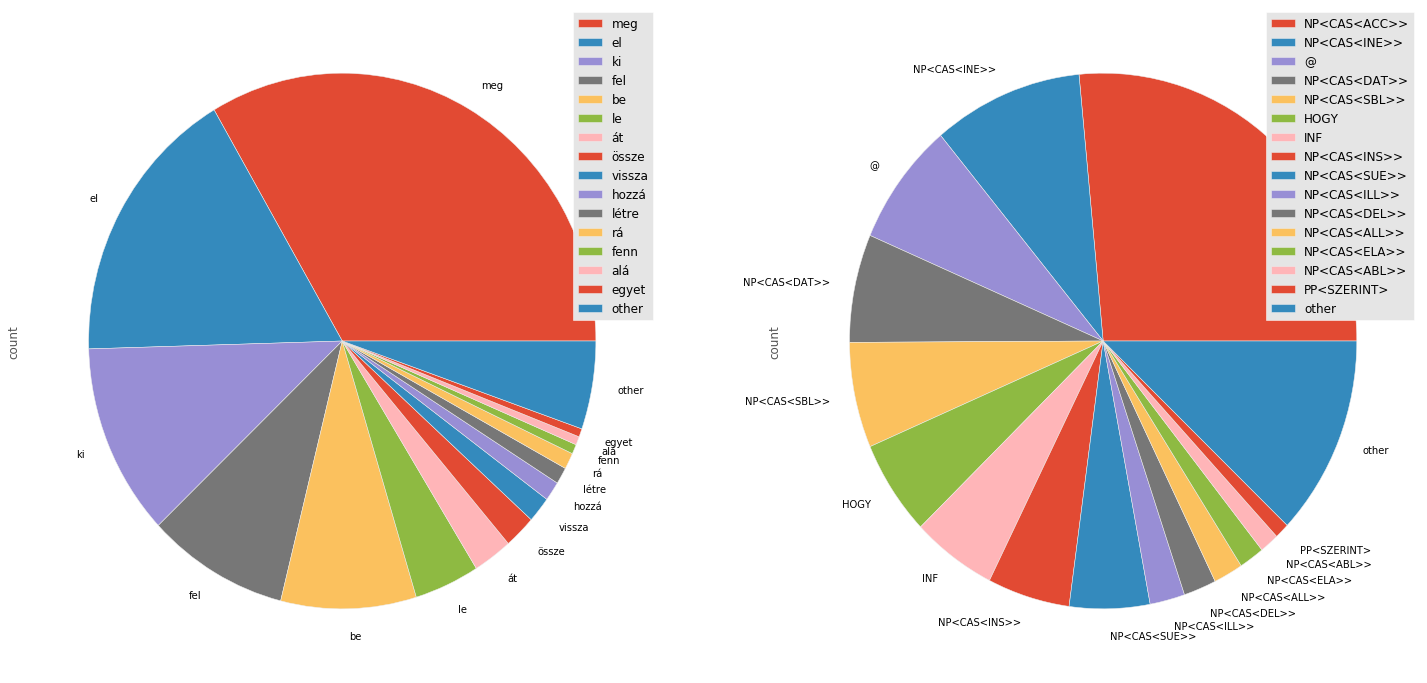

In [123]:
capped_sorted_list(preverb_sums, by='B', cutoff=15).rename(columns={'B': 'count'})
capped_sorted_list(frame_sums, by='C', cutoff=15).rename(columns={'C': 'count'})

matplotlib.pyplot.rcParams['figure.figsize'] = (25, 12)
fig, axs = matplotlib.pylab.subplots(1,2)
capped_sorted_list(preverb_sums, by='B', cutoff=15).rename(columns={'B': 'count'}).plot(y='count', kind='pie', ax=axs[0])
capped_sorted_list(frame_sums, by='C', cutoff=15).rename(columns={'C': 'count'}).plot(y='count', kind='pie', ax=axs[1])

In [ ]:
all_frames = df.frame_freq.sum()

df_to_join = split_frames(normalize_frames(add_preverb_column(df2)))

frame_counts = df_to_join[['frame', 'verb']].rename(columns={'verb': 'count'}).groupby('frame').count()
preverb_counts = df_to_join[['preverb', 'verb']].rename(columns={'verb': 'count'}).groupby('preverb').count()
display(frame_counts)
display(preverb_counts)

frame_sums = df2[['frame', 'frame_freq']].rename(columns={'frame_freq': 'C'}).groupby('frame').sum()
preverb_sums = df2[['preverb', 'frame_freq']].rename(columns={'frame_freq': 'B'}).groupby('preverb').sum()

print(cells)
print(frame_sums)
print(preverb_sums)
display(cells)
display(preverb_sums)
display(frame_sums)

from scipy.stats import fisher_exact

full = cells.join(preverb_sums).join(frame_sums)
full['D'] = all_frames + full.A - full.B - full.C
full['Fisher'] = full.apply(lambda row: scipy.stats.fisher_exact([[row.A, row.B - row.A], [row.C, row.D - row.C]])[1], axis=1)
display(full)

#aha = pd.DataFrame({'apple': [0, 1, 2], 'banana': [3, 4, 5], 'cherry': ['good', 'bad', 'good']})
#aha['apple'][aha.cherry == 'bad'] = np.nan
#aha.loc[aha.cherry == 'bad', ['apple', 'banana']] = aha.loc[aha.cherry == 'bad', ['banana', 'apple']]
#aha.loc[aha.cherry == 'bad', 'apple'] = aha.banana + 1
#display(aha)
#aha.loc[aha.cherry == 'good', ['apple', 'banana']] = (aha[['banana','apple']] * 2).values
#aha.loc[aha.cherry == 'good', ['apple', 'banana']] = pd.concat([aha['banana'] * 3, aha['apple'] * 2], axis=1)
#display(aha)